In [33]:
S2_5B_Dataset_22Classes_Map = dict(
    # class_L1_{L1中的标签号}_{L1中的标签名称}=[L3级标签的值]
    Classes_Map_L1=dict(
        class_L1_0_Other_land=[0],
        class_L1_1_Vegetation=[1, 2, 3, 4, 5, 6, 7],
        class_L1_2_Water=[8, 9, 10],
        class_L1_3_Artificial_surface=[11, 12, 13, 14, 15, 16, 17, 18, 19],
        class_L1_4_Bare_land=[20],
        class_L1_5_Ice_snow=[21],
    ),
    # class_L2_{L1级标签中的标签值}_{L2级标签中的标签值}_{L2级标签中的标签名称}
    Classes_Map_L2=dict(
        class_L2_0_0_Other_land=[0],
        class_L2_1_1_Crop_land=[1, 2, 3],
        class_L2_1_2_Garden_land=[4],
        class_L2_1_3_Forest=[5],
        class_L2_1_4_Grassland=[6, 7],
        class_L2_2_5_Water=[8, 9, 10],
        class_L2_3_6_Factory_Shopping_malls=[11],
        class_L2_3_7_Residence=[12, 13],
        class_L2_3_8_Public_area=[14, 15],
        class_L2_3_9_Transportation_infrastructure=[16,17,18,19],
        class_L2_4_10_Bare_land=[20],
        class_L2_5_11_Ice_snow=[21],
    ),
    # class_L3_{L1级标签中的标签值}_{L2级标签中的标签值}_{L3级标签中的标签值}_{L3级标签中的标签名称}
    Classes_Map_L3=dict(
        class_L3_0_0_0_Other_land=[0],
        class_L3_1_1_1_Paddy_field=[1],
        class_L3_1_1_2_Irrigated_field=[2],
        class_L3_1_1_3_Dry_cropland=[3],
        class_L3_1_2_4_Garden_land=[4],
        class_L3_1_3_5_Forest=[5],
        class_L3_1_4_6_Natural_meadow=[6],
        class_L3_1_4_7_Artificial_meadow=[7],
        class_L3_1_5_8_River=[8],
        class_L3_1_5_9_Lake=[9],
        class_L3_1_5_10_Pond=[10],
        class_L3_1_6_11_Factory_shopping_malls=[11],
        class_L3_1_7_12_Urban_residential=[12],
        class_L3_1_7_13_Rural_residential=[13],
        class_L3_1_8_14_Stadium=[14],
        class_L3_1_8_15_Park_Square=[15],
        class_L3_1_9_16_Road=[16],
        class_L3_1_9_17_Overpass=[17],
        class_L3_1_9_18_Railway_station=[18],
        class_L3_1_9_19_Airport=[19],
        class_L3_1_10_20_Bare_land=[20],
        class_L3_1_11_21_ice_snow=[21]
    )
)   

In [34]:
classes_map = S2_5B_Dataset_22Classes_Map

In [35]:
classes_map.keys()

dict_keys(['Classes_Map_L1', 'Classes_Map_L2', 'Classes_Map_L3'])

In [36]:
len(classes_map.keys())

3

In [37]:
from mmseg.models.losses.cross_entropy_loss import CrossEntropyLoss

In [38]:
loss_ce = CrossEntropyLoss(loss_name='atl_loss_ce') # 不分级，默认为 1 级

/opt/AI-Tianlong/openmmlab/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:251: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [39]:
import numpy as np
import torch
pred = torch.rand(2, 22+12+6, 512, 512)
pred.shape

torch.Size([2, 40, 512, 512])

In [40]:
label = torch.randint(0,21,(2,512,512))
label.shape

torch.Size([2, 512, 512])

In [41]:
loss_ce_value = loss_ce(pred, label)
loss_ce_value

tensor(3.7292)

In [45]:
_loss_name = 'atl_loss'
loss_ce_dict = dict()
if classes_map == None:
    # 不分级，默认为 1 级
    loss_ce_dict[f'{_loss_name}_ce'] = CrossEntropyLoss()#loss_name='atl_loss_ce') 
    # loss_ce = CrossEntropyLoss(loss_name='atl_loss_ce') 
else:
    loss_ce_num = len(classes_map.keys())  # 识别分为几级标签
    for loss_ce_index in range(loss_ce_num):
        loss_ce_dict[f'{_loss_name}_ce_L{loss_ce_index+1}'] = CrossEntropyLoss()

In [46]:
loss_ce_dict

{'atl_loss_ce_L1': CrossEntropyLoss(avg_non_ignore=False),
 'atl_loss_ce_L2': CrossEntropyLoss(avg_non_ignore=False),
 'atl_loss_ce_L3': CrossEntropyLoss(avg_non_ignore=False)}

In [134]:
def convert_low_level_label_to_High_level(label, classes_map):
    """Convert low level label to High level label.
        e.g.:
          convert L3 label (num_classes=22)  to 
          L2 label (num_classes=12) or L1 label (num_classes=6)

    Args:
        label (Tensor): L3 label.  [2, 512, 512]
        classes_map (dict): Classes map. 

    Returns:
        Tensor: Lx label.
    """                                                     
    label_list = list()                                       # 转换 L3 (low level) --> L1 L2 (hgih level)
    for level_name, high_level_dict in list(classes_map.items())[:-1]:
        high_level_label = torch.zeros_like(label).fill_(255) # 255 is the ignore index
        for high_level_label_value, high_level_key in enumerate(high_level_dict):
            low_level_label_list = high_level_dict[high_level_key]
            for low_level_label in low_level_label_list:
                high_level_label[label == low_level_label] = high_level_label_value
        label_list.append(high_level_label)
    
    label_list.append(label) # L3 label
    return label_list #[L1级label, L2级label, L3级label]

In [135]:
label_path_1 = '/opt/AI-Tianlong/openmmlab/mmsegmentation/data/0-atl-paper-s2/0-S2_5B-21类-包含雪21/ann_dir/val/S2_SR_2019_GF2_PMS1__L1A0001064454-MSS1_0_1.tif'
label_path_2 = '/opt/AI-Tianlong/openmmlab/mmsegmentation/data/0-atl-paper-s2/0-S2_5B-21类-包含雪21/ann_dir/val/S2_SR_2019_GF2_PMS1__L1A0001064454-MSS1_0_2.tif'

In [136]:
img_path_1 = '/opt/AI-Tianlong/openmmlab/mmsegmentation/data/0-atl-paper-s2/0-S2_5B-21类-包含雪21/img_dir/val/S2_SR_2019_GF2_PMS1__L1A0001064454-MSS1_0_1.tif'
img_path_2 = '/opt/AI-Tianlong/openmmlab/mmsegmentation/data/0-atl-paper-s2/0-S2_5B-21类-包含雪21/img_dir/val/S2_SR_2019_GF2_PMS1__L1A0001064454-MSS1_0_2.tif'

In [137]:
from PIL import Image
import numpy as np
label_np_1 = np.array(Image.open(label_path_1))
label_np_2 = np.array(Image.open(label_path_2))

label_np = np.stack([label_np_1, label_np_2], axis=0)
label_np.shape
label_tensor = torch.from_numpy(label_np)
label_tensor.shape

torch.Size([2, 512, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


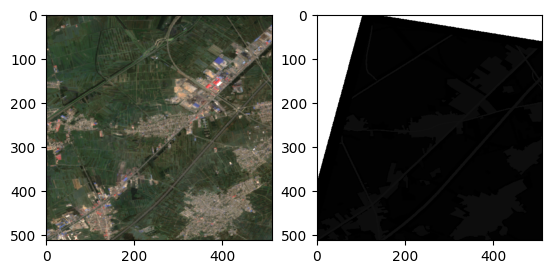

In [138]:
from osgeo import gdal
from matplotlib import pyplot as plt
img_np_1 = gdal.Open(img_path_1).ReadAsArray().transpose(1,2,0)
img_np_2 = gdal.Open(img_path_2).ReadAsArray().transpose(1,2,0)

img_vis_1[:,:,0] = img_np_1[:,:,2]
img_vis_1[:,:,1] = img_np_1[:,:,1]
img_vis_1[:,:,2] = img_np_1[:,:,0]

plt.subplot(1,2,1)
plt.imshow(img_vis_1*3)
plt.subplot(1,2,2)
plt.imshow(label_np[0],cmap='gray')
plt.show()
plt.show()

In [139]:
label_list = convert_low_level_label_to_High_level(label_tensor, classes_map)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


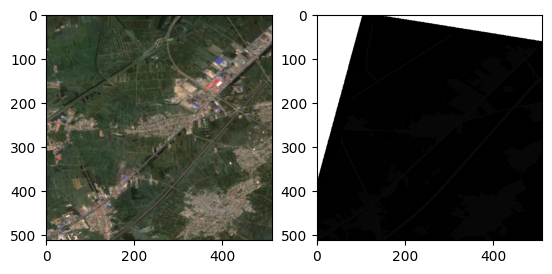

In [143]:
high_label_np = label_list[0].numpy()

plt.subplot(1,2,1)
plt.imshow(img_vis_1*3)
plt.subplot(1,2,2)
plt.imshow(label_list[1][0], cmap='gray')
plt.show()
plt.show()

Image.fromarray(label_list[0][0].numpy().astype(np.uint8)).save('./L1-label.png')
Image.fromarray(label_list[1][0].numpy().astype(np.uint8)).save('./L2-label.png')
Image.fromarray(label_list[2][0].numpy().astype(np.uint8)).save('./L3-label.png')

# 上面的都验证成功，开始计算loss

In [144]:
# 构造层级Loss函数
loss_ce_dict = dict()
if classes_map == None:
    # 不分级，默认为 1 级
    loss_ce_dict[f'{_loss_name}_ce'] = CrossEntropyLoss(loss_name=f'{_loss_name}_ce')
    # loss_ce = CrossEntropyLoss(loss_name='atl_loss_ce') 
else:
    loss_ce_num = len(classes_map.keys())  # 识别分为几级标签
    for loss_ce_index in range(loss_ce_num):
        loss_ce_dict[f'{_loss_name}_ce_L{loss_ce_index+1}'] = CrossEntropyLoss(
            loss_name=f'{_loss_name}_ce_L{loss_ce_index+1}')

/opt/AI-Tianlong/openmmlab/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:251: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [147]:
loss_ce_dict

{'atl_loss_ce_L1': CrossEntropyLoss(avg_non_ignore=False),
 'atl_loss_ce_L2': CrossEntropyLoss(avg_non_ignore=False),
 'atl_loss_ce_L3': CrossEntropyLoss(avg_non_ignore=False)}

In [150]:
cls_score = torch.rand(2, 6+12+22, 512, 512)

In [151]:
for loss_ce_name in loss_ce_dict:
    loss_cls = loss_ce_dict[loss_ce_name](
                cls_score,
                label,
                class_weight=1.0,
                ignore_index=255)

TypeError: mmseg.models.losses.cross_entropy_loss.cross_entropy() got multiple values for keyword argument 'class_weight'

In [1]:
S2_5B_Dataset_22Classes_Map = dict(
    # class_L1_{L1中的标签号}_{L1中的标签名称}=[L3级标签的值]
    Classes_Map_L1=dict(
        class_L1_0_Other_land=[0],
        class_L1_1_Vegetation=[1, 2, 3, 4, 5, 6, 7],
        class_L1_2_Water=[8, 9, 10],
        class_L1_3_Artificial_surface=[11, 12, 13, 14, 15, 16, 17, 18, 19],
        class_L1_4_Bare_land=[20],
        class_L1_5_Ice_snow=[21],
    ),
    # class_L2_{L1级标签中的标签值}_{L2级标签中的标签值}_{L2级标签中的标签名称}
    Classes_Map_L2=dict(
        class_L2_0_0_Other_land=[0],
        class_L2_1_1_Crop_land=[1, 2, 3],
        class_L2_1_2_Garden_land=[4],
        class_L2_1_3_Forest=[5],
        class_L2_1_4_Grassland=[6, 7],
        class_L2_2_5_Water=[8, 9, 10],
        class_L2_3_6_Factory_Shopping_malls=[11],
        class_L2_3_7_Residence=[12, 13],
        class_L2_3_8_Public_area=[14, 15],
        class_L2_3_9_Transportation_infrastructure=[16,17,18,19],
        class_L2_4_10_Bare_land=[20],
        class_L2_5_11_Ice_snow=[21],
    ),
    # class_L3_{L1级标签中的标签值}_{L2级标签中的标签值}_{L3级标签中的标签值}_{L3级标签中的标签名称}
    Classes_Map_L3=dict(
        class_L3_0_0_0_Other_land=[0],
        class_L3_1_1_1_Paddy_field=[1],
        class_L3_1_1_2_Irrigated_field=[2],
        class_L3_1_1_3_Dry_cropland=[3],
        class_L3_1_2_4_Garden_land=[4],
        class_L3_1_3_5_Forest=[5],
        class_L3_1_4_6_Natural_meadow=[6],
        class_L3_1_4_7_Artificial_meadow=[7],
        class_L3_1_5_8_River=[8],
        class_L3_1_5_9_Lake=[9],
        class_L3_1_5_10_Pond=[10],
        class_L3_1_6_11_Factory_shopping_malls=[11],
        class_L3_1_7_12_Urban_residential=[12],
        class_L3_1_7_13_Rural_residential=[13],
        class_L3_1_8_14_Stadium=[14],
        class_L3_1_8_15_Park_Square=[15],
        class_L3_1_9_16_Road=[16],
        class_L3_1_9_17_Overpass=[17],
        class_L3_1_9_18_Railway_station=[18],
        class_L3_1_9_19_Airport=[19],
        class_L3_1_10_20_Bare_land=[20],
        class_L3_1_11_21_ice_snow=[21]
    )
)   

In [2]:
classes_map = S2_5B_Dataset_22Classes_Map

In [8]:
for x in classes_map:
    print(x)

Classes_Map_L1
Classes_Map_L2
Classes_Map_L3


In [53]:
num_levels_classes = list()
num_levels_classes.append(0)
for level_name, high_level_dict in list(classes_map.items()):
    num_levels_classes.append(len(high_level_dict))
num_levels_classes

[0, 6, 12, 22]

In [54]:
classes_range = list()
for i in range(len(num_levels_classes)-1):
    classes_range.append([num_levels_classes[i], num_levels_classes[i]+num_levels_classes[i+1]])
    num_levels_classes[i+1] = num_levels_classes[i]+num_levels_classes[i+1]
classes_range

[[0, 6], [6, 18], [18, 40]]

In [6]:
for level_name, high_level_dict in list(classes_map.items()):
    print(len(high_level_dict))

6
12
22


In [56]:
import torch
pred = torch.randn(2, 40, 512, 512)
classes_range = classes_range


In [57]:
pred_level_list = list()
for i in range(len(classes_map)):
    pred_level_list.append(pred[:, classes_range[i][0]:classes_range[i][1], ...])


In [62]:
pred_level_list[2].shape

torch.Size([2, 22, 512, 512])